# **SC1015: Mini Project**

---

>Group 2: Ng Jia Xin, Angelina Delia Sutiarto, Spyridon Giakoumatos

Our group will focus on the `okcupid_profiles.csv` file. 

In this notebook we will go through the steps we took to clean the data consisting of numerical, categorical and textual data. Followed by how we used this data to determine one users compatibility to another user.

---

### **Essential Libraries**

Libraries required are imported

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import string


---

## **Cleaning The Data**

At a first glance this data was filled with many issues such as missing values, having catergorical & textual data. Hence I will outline the steps we took to clean this data.

1. Discarding data with too many missing values (as it might skew machine learning algoritms) and / or filling missing values
2. Converting all catergorical data to `One Hot` data to allow for ease of processing
3. Converted all numerical data to range between 0 and 1 using `min_max_scaler`
4. Converted textual data to numerical data (outline further below)

In [2]:
okcdata = pd.read_csv('okcupid_profiles.csv')
okcData = pd.DataFrame(okcdata)
okcData = okcData[:-40000] #original dataset size of 60k was too big for laptops to process in a reasonable time, hence we had to cut the set down
okcData.rename(columns={'essay0': 'self summary', 'essay1': 'what I have been doing in life', 'essay2': 'i am good at...', 'essay3': 'first thing people notice is', 'essay4': 'favourite books, movies etc.', 'essay5': '6 neccessary things', 'essay6': 'spent a lot of time thinking about...', 'essay7': 'typical activity on Fri night', 'essay8': 'most private thing I will admit', 'essay9': 'you should message me if'}, inplace=True)
okcData.head() #renaming the columns to appropriate names for ease of understanding

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,self summary,what I have been doing in life,i am good at...,first thing people notice is,"favourite books, movies etc.",6 neccessary things,spent a lot of time thinking about...,typical activity on Fri night,most private thing I will admit,you should message me if
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


### **Dropping Irrelevant Columns**

For the questions, we have decided to drop the columns stated below that are not as important in terms of compatibility. 
columns: 

13, "last_online" --> irrelevant to compatibility

22, "what I have been doing in life" --> we decided to drop this as it is similar to the column "job"

24, "first thing people notice is" --> irrelevant to compatibility

26, "6 necessary things" --> irrelevant to compatibility

27, "spent a lot of time thinking about..." --> irrelevant to compatibility

29, "most private thing I will admit" --> irrelevant to compatibility

30, "you should message me if" --> irrelevant to compatibility

"income" --> too many missing values

"offspring" --> too many missing values

In [3]:
okcData.drop(okcData.columns[[13, 22, 24, 26, 27, 29, 30]], axis=1, inplace=True)

### **Cleaning Ethnicity Data**

In [4]:
pd.set_option("display.max_rows", None)
okcData.ethnicity.value_counts(normalize=True)

ethnicity
white                                                                                                      0.608113
asian                                                                                                      0.110218
hispanic / latin                                                                                           0.050593
black                                                                                                      0.036518
other                                                                                                      0.033913
hispanic / latin, white                                                                                    0.024050
indian                                                                                                     0.019783
asian, white                                                                                               0.013798
white, other                                                  

In [5]:
def create_ethnicity_columns(data):
    ethnicities_list = ['White', 'Asian', 'Hispanic / Latin', 'Black', 'Other', 'Indian', 'Pacific Islander', 'Middle Eastern', 'Native American']

    for ethnicity in ethnicities_list:
        data[ethnicity] = 0
        data.loc[data['ethnicity'].str.contains(ethnicity, case=False, na=False), ethnicity] = 1
    return data

okcData = create_ethnicity_columns(okcData)
okcData.drop(['ethnicity'],axis=1,inplace=True)
pd.set_option('display.max_columns', None)

### **Cleaning Height Data**

Here we opted to make the height data one hot, by making various height "buckets" to fit the data into

In [6]:
okcData['height_feet'] = round(okcData['height']*0.08333,1)
okcData.height_feet.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    19946.000000
mean         5.695242
std          0.329478
min          0.200000
25%          5.500000
50%          5.700000
75%          5.900000
90%          6.100000
95%          6.200000
99%          6.300000
max          7.900000
Name: height_feet, dtype: float64

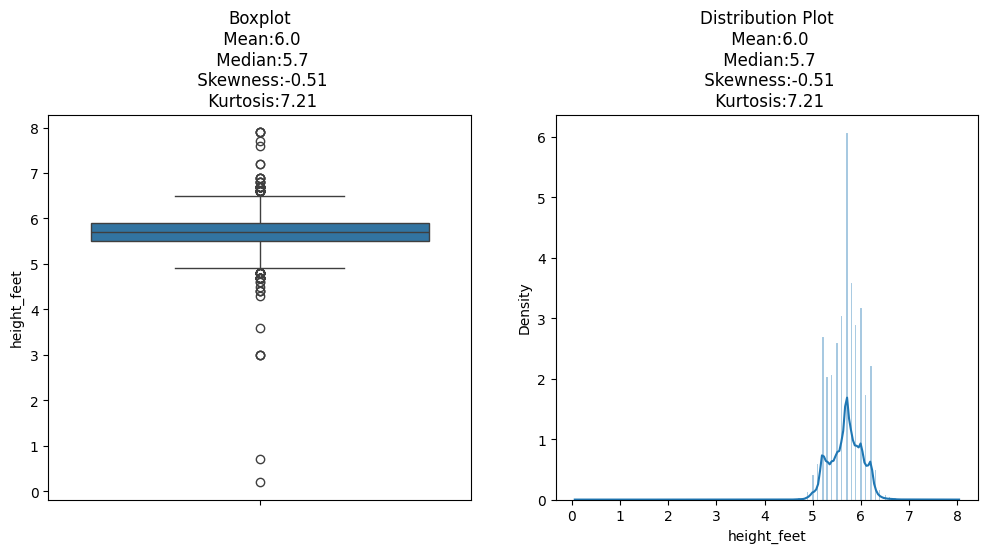

In [7]:
plt.figure(figsize=(12,5))

skewness = round(okcData.height_feet.skew(),2)
kurtosis = round(okcData.height_feet.kurtosis(),2)
mean = round(np.mean(okcData.height_feet),0)
median = np.median(okcData.height_feet)

plt.subplot(1,2,1)
sns.boxplot(y=okcData.height_feet)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.subplot(1,2,2)
sns.histplot(
    okcData["height_feet"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('Distribution Plot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.show()

In [8]:
okcData['height_bin'] = pd.cut(okcData.height_feet,bins=[3,4,5,6,7,8],labels=['3-4feets','4-5feets','5-6feets','6-7feets','7-8feets'],right=False)
heights = pd.get_dummies(okcData.height_bin,prefix='height_')
heights = heights.applymap(lambda x: 1 if x == True else 0)
okcData = pd.concat([okcData,heights], axis=1)
okcData.drop(['height','height_feet','height_bin'],axis=1,inplace=True)
pd.set_option('display.max_columns', None)


### **Cleaning Income Data**

Here we found that we needed to omit income data as there were too many missing values

In [9]:
okcData.income.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count      19946.000000
mean       19968.612002
std        96337.004307
min           -1.000000
25%           -1.000000
50%           -1.000000
75%           -1.000000
90%        50000.000000
95%       100000.000000
99%       250000.000000
max      1000000.000000
Name: income, dtype: float64

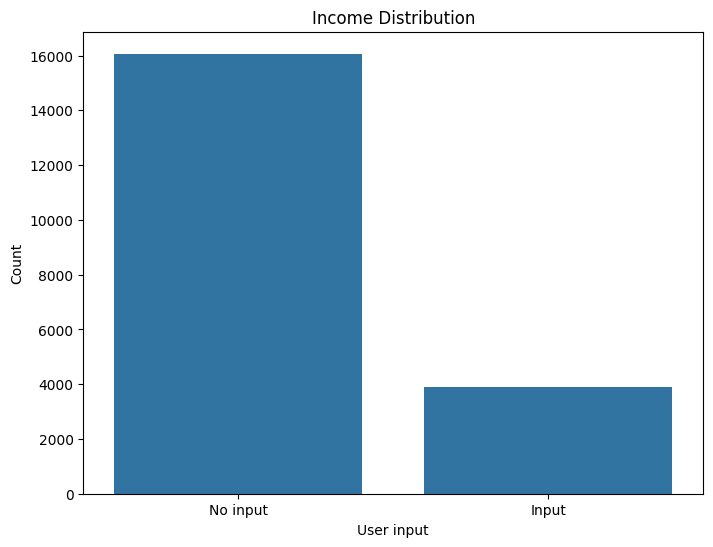

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

okcData['income_category'] = np.where(okcData['income'] == -1, 'No input', 'Input')

income_counts = okcData['income_category'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=income_counts.index, y=income_counts.values)
plt.title('Income Distribution')
plt.xlabel('User input')
plt.ylabel('Count')
plt.show()

Since the number of users who did not input anything for the column "income" is significantly higher than the number of users who did input their income, we have decided to drop income from the data set to ensure the final results are not skewed.

In [11]:
okcData.drop(['income', 'income_category'], axis=1, inplace=True)

### **Cleaning Job Data**

In [12]:
okcData.job.value_counts(normalize=True)

job
other                                0.141549
science / tech / engineering         0.097051
student                              0.095197
computer / hardware / software       0.094270
artistic / musical / writer          0.087722
sales / marketing / biz dev          0.081465
medicine / health                    0.070630
education / academia                 0.065183
executive / management               0.046353
entertainment / media                0.044962
banking / financial / real estate    0.042876
hospitality / travel                 0.026827
law / legal services                 0.026537
construction / craftsmanship         0.021264
clerical / administrative            0.015007
political / government               0.013558
rather not say                       0.007532
transportation                       0.007474
unemployed                           0.005388
retired                              0.005041
military                             0.004114
Name: proportion, dtype: float

Since the last 5 jobs are less than 1%, we combine them into 'other'

In [13]:
okcData['job'] = okcData['job'].replace(('0','rather not say','transportation','unemployed','retired','military'),
                             ('other','other','other','other','other','other'))

In [14]:
jobs = pd.get_dummies(okcData.job,prefix='job_')
jobs = jobs.applymap(lambda x: 1 if x == True else 0)
okcData = pd.concat([okcData,jobs], axis=1)
okcData.drop('job',axis=1,inplace=True)

### **Cleaning Location Data**

Perform one hot encoding, separating cities into different "buckets" and indicating `1` and `0` appropriately.

In [15]:
pd.set_option("display.max_rows", None)
okcData.location.value_counts(normalize=True)

location
san francisco, california          0.514589
oakland, california                0.120726
berkeley, california               0.074952
san mateo, california              0.021257
palo alto, california              0.017698
alameda, california                0.016344
emeryville, california             0.012935
hayward, california                0.012684
san rafael, california             0.012183
redwood city, california           0.011732
daly city, california              0.011130
san leandro, california            0.011080
walnut creek, california           0.010829
menlo park, california             0.009275
vallejo, california                0.009024
richmond, california               0.007019
burlingame, california             0.006919
mountain view, california          0.006518
el cerrito, california             0.006167
castro valley, california          0.005816
stanford, california               0.005766
south san francisco, california    0.005715
novato, california     

In [16]:
locn = okcData[['location']].copy()
split_location = locn.location.str.split(',', expand=True)

if len(split_location.columns) == 2:
    locn[['city', 'state']] = split_location
else:
    locn['city'] = split_location[0]  
    locn['state'] = split_location[1] 

locd = pd.get_dummies(locn['city'])
locd = locd.applymap(lambda x: 1 if x == True else 0)
locn = pd.concat([locn, locd], axis=1)
locn.head()

,location,city,state,alameda,albany,astoria,atherton,bellwood,belmont,belvedere tiburon,benicia,berkeley,billings,bolinas,boulder,brea,brisbane,burlingame,canyon country,castro valley,chicago,colma,concord,cork,corte madera,crockett,daly city,east palo alto,edinburgh,el cerrito,el granada,el sobrante,emeryville,fairfax,forest knolls,foster city,freedom,fremont,glencove,grand rapids,green brae,hacienda heights,half moon bay,hayward,hercules,hillsborough,honolulu,kensington,kentfield,lafayette,lagunitas,larkspur,las vegas,leander,london,los angeles,madrid,magalia,martinez,menlo park,mill valley,millbrae,milwaukee,montara,moraga,moss beach,mountain view,new orleans,new york,nha trang,novato,oakland,olema,orange,orinda,pacifica,palo alto,peoria,petaluma,piedmont,pinole,pleasant hill,point richmond,portland,redwood city,redwood shores,richmond,riverside,rodeo,rohnert park,ross,sacramento,san anselmo,san bruno,san carlos,san diego,san francisco,san geronimo,san jose,san leandro,san lorenzo,san mateo,san pablo,san quentin,san rafael,santa clara,santa cruz,santa monica,sausalito,seaside,south san francisco,south wellfleet,stanford,stinson beach,studio city,tiburon,tucson,union city,utica,vallejo,walnut creek,west oakland,westlake,woodacre,woodbridge,woodside
0,"south san francisco, california",south san francisco,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"oakland, california",oakland,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"san francisco, california",san francisco,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"berkeley, california",berkeley,california,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"san francisco, california",san francisco,california,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
okcData = pd.concat([okcData, locn], axis=1)
okcData.drop(['location', 'city', 'state'], axis=1, inplace=True)

### **Cleaning Offspring Data**

Similar to income data, we decided to drop offspring data due to large amount of missing values making this an ineffective predictor for match compatibility.

In [18]:
okcData.offspring.value_counts(normalize=True)

offspring
doesn't have kids                          0.313971
doesn't have kids, but might want them     0.159153
doesn't have kids, but wants them          0.143423
doesn't want kids                          0.118529
has kids                                   0.076666
has a kid                                  0.075923
doesn't have kids, and doesn't want any    0.049913
has kids, but doesn't want more            0.017463
has a kid, but doesn't want more           0.011395
has a kid, and might want more             0.008918
wants kids                                 0.008298
might want kids                            0.007803
has kids, and might want more              0.004706
has a kid, and wants more                  0.002849
has kids, and wants more                   0.000991
Name: proportion, dtype: float64

Since almost 60% of users did not input anything for the section "offspring", we have decided to drop it from our dataset to ensure the final results would not be skewed. 

In [19]:
okcData.drop(['offspring'], axis=1, inplace=True)

### **Cleaning Pets Data**

Rationale here was to group users into different catergories via one hot encoding.

In [20]:
okcData.pets.value_counts(normalize=True)

pets
likes dogs and likes cats          0.372236
likes dogs                         0.178547
likes dogs and has cats            0.103066
has dogs                           0.102616
has dogs and likes cats            0.061989
likes dogs and dislikes cats       0.048722
has dogs and has cats              0.037329
has cats                           0.034105
likes cats                         0.029233
has dogs and dislikes cats         0.014392
dislikes dogs and dislikes cats    0.005997
dislikes dogs and likes cats       0.005772
dislikes cats                      0.002923
dislikes dogs and has cats         0.001874
dislikes dogs                      0.001199
Name: proportion, dtype: float64

In [21]:
def pet_like(txt):
    if isinstance(txt, str):
        if 'likes dogs' in txt and 'likes cats' in txt:
            return 'dog and cat'
        elif 'likes dogs' in txt:
            return 'dog'
        elif 'likes cats' in txt:
            return 'cat'
        else:
            return 'none'
    else:
        return 'none' 

okcData['pet_like'] = okcData['pets'].astype(str).apply(pet_like)

In [22]:
def pet_owned(txt):
    if isinstance(txt, str):
        if 'has dogs and has cats' in txt:
            return 'dog and cat'
        elif 'has dogs' in txt:
            return 'dog'
        elif 'has cats' in txt:
            return 'cat'
        else:
            return 'none'
    else:
        return 'none'  
    
okcData['pet_owned'] = okcData['pets'].astype(str).apply(pet_owned)

In [23]:
petld = pd.get_dummies(okcData.pet_like, prefix='likes pet ')
petod = pd.get_dummies(okcData.pet_owned, prefix='owns pet ')
okcData = pd.concat([okcData, petld, petod], axis=1)
okcData.replace({True: 1, False: 0}, inplace=True)
okcData.drop(['pet_like', 'pet_owned', 'pets'], axis=1, inplace=True)

if 'likes pet _dog' in okcData.columns:
    okcData.loc[okcData['likes pet _dog'] == 1, 'likes pet _dog'] = 1

if 'likes pet _cat' in okcData.columns:
    okcData.loc[okcData['likes pet _cat'] == 1, 'likes pet _cat'] = 1

if 'likes pet _dog and cat' in okcData.columns:
    okcData.loc[okcData['likes pet _dog and cat'] == 1, 'likes pet _dog'] = 1
    okcData.loc[okcData['likes pet _dog and cat'] == 1, 'likes pet _cat'] = 1
    okcData.drop('likes pet _dog and cat', axis=1, inplace=True)

if 'likes pet _none' in okcData.columns:
    okcData.loc[okcData['likes pet _none'] == 1, 'likes pet _dog'] = 0
    okcData.loc[okcData['likes pet _none'] == 1, 'likes pet _cat'] = 0
    okcData.drop('likes pet _none', axis=1, inplace=True)

if 'owns pet _dog' in okcData.columns:
    okcData.loc[okcData['owns pet _dog'] == 1, 'owns pet _dog'] = 1

if 'owns pet _cat' in okcData.columns:
    okcData.loc[okcData['owns pet _cat'] == 1, 'owns pet _cat'] = 1

if 'owns pet _dog and cat' in okcData.columns:
    okcData.loc[okcData['owns pet _dog and cat'] == 1, 'owns pet _dog'] = 1
    okcData.loc[okcData['owns pet _dog and cat'] == 1, 'owns pet _cat'] = 1
    okcData.drop('owns pet _dog and cat', axis=1, inplace=True)

if 'owns pet _none' in okcData.columns:
    okcData.loc[okcData['owns pet _none'] == 1, 'owns pet _dog'] = 0
    okcData.loc[okcData['owns pet _none'] == 1, 'owns pet _cat'] = 0
    okcData.drop('owns pet _none', axis=1, inplace=True)

### **Cleaning Age Data**

Similar to height, the age data was divided into bins for one hot encoding.

In [24]:
okcData.age.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    19946.000000
mean        32.185200
std          9.414075
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
90%         45.000000
95%         52.000000
99%         63.000000
max        110.000000
Name: age, dtype: float64

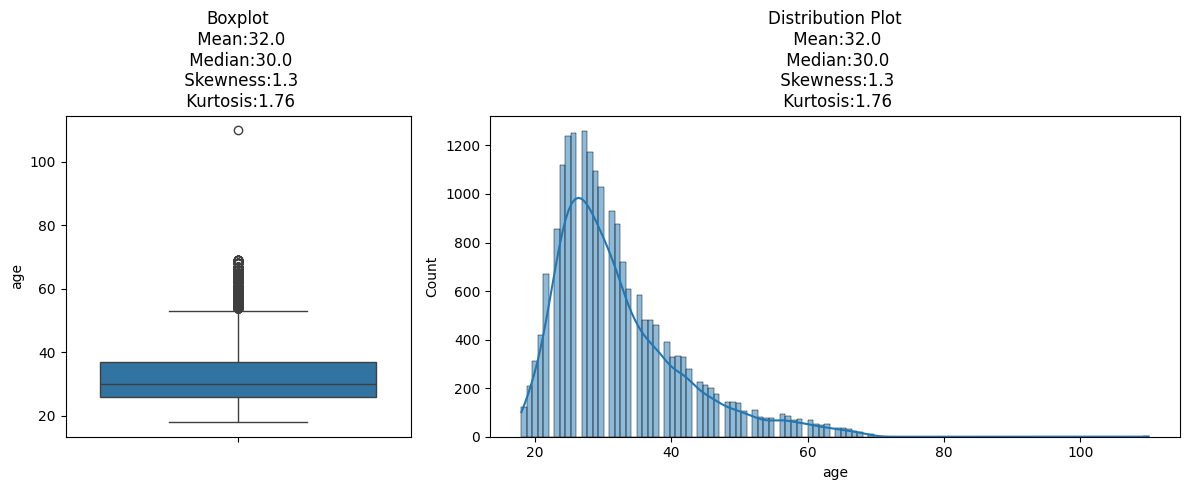

In [25]:
plt.figure(figsize=(12, 5))

skewness = round(okcData.age.skew(), 2)
kurtosis = round(okcData.age.kurtosis(), 2)
mean = round(np.mean(okcData.age), 0)
median = np.median(okcData.age)

# Define the layout of the subplots
gs = plt.GridSpec(1, 2, width_ratios=[1, 2])

# First subplot
plt.subplot(gs[0])
sns.boxplot(y=okcData.age)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean, median, skewness, kurtosis))

# Second subplot
plt.subplot(gs[1])
sns.histplot(okcData.age, kde=True) 
plt.title('Distribution Plot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean, median, skewness, kurtosis))

plt.tight_layout() 
plt.show()

In [26]:
okcData['age_bin'] = pd.cut(okcData.age, bins=[16,24,30,40,50,70],labels=['16-24','25-30','31-40','41-50','50+'])
aged = pd.get_dummies(okcData.age_bin,prefix='age_')
okcData = pd.concat([okcData,aged], axis=1)
okcData.drop(['age','age_bin'],axis=1,inplace=True)

### **Cleaning Drink Data**

An instance of categorical data. I paired each category with an appropriate value between 0 to 1.


In [27]:
okcData.drinks.value_counts(normalize=True)

drinks
socially       0.735422
rarely         0.104215
often          0.090482
not at all     0.056729
very often     0.007765
desperately    0.005388
Name: proportion, dtype: float64

In [28]:
def categorize_drinks(text):
    if pd.isna(text):
        return 0 
    text = text.lower()
    if 'not at all' in text:
        return 1.0
    elif 'often' in text:
        return 0.75
    elif 'socially' in text:
        return 0.5
    elif 'often' in text:
        return 0.25
    else: #very often & desperately
        return 0

In [29]:
okcData['drinks'] = okcData['drinks'].apply(categorize_drinks)
okcData['drinks'].value_counts()

drinks
0.50    13923
0.00     3089
0.75     1860
1.00     1074
Name: count, dtype: int64

In [30]:
okcData.drop(['drinks'],axis=1,inplace=True)

### **Cleaning Drug Data**

Similar to above, categorical data is converted to numerical

In [31]:
okcData.drugs.value_counts(normalize=True)

drugs
never        0.822057
sometimes    0.168852
often        0.009092
Name: proportion, dtype: float64

In [32]:
def categorize_drugs(text):
    if pd.isna(text):
        return 0 
    text = text.lower()
    if 'often' in text:
        return 1.0
    elif 'sometimes' in text:
        return 0.5
    else:
        return 0

In [33]:
okcData['drugs'] = okcData['drugs'].apply(categorize_drugs)
okcData['drugs'].value_counts()

drugs
0.0    17245
0.5     2563
1.0      138
Name: count, dtype: int64

In [34]:
okcData.drop(['drugs'],axis=1,inplace=True)

### **Cleaning Education Data**

Many different categories, hence we group them up in the most logical way then convert them to numerical values

In [35]:
okcData.education.value_counts(normalize=True)

education
graduated from college/university    0.445133
graduated from masters program       0.166685
working on college/university        0.111762
working on masters program           0.030194
graduated from two-year college      0.028616
graduated from high school           0.025349
graduated from ph.d program          0.023941
graduated from law school            0.020899
working on two-year college          0.020617
dropped out of college/university    0.019603
working on ph.d program              0.018589
college/university                   0.014703
graduated from space camp            0.011717
dropped out of space camp            0.009351
graduated from med school            0.009182
working on space camp                0.009069
working on law school                0.005746
two-year college                     0.004845
working on med school                0.004563
dropped out of two-year college      0.003943
masters program                      0.002986
dropped out of masters p

In [36]:
def categorize_education(text):
    if pd.isna(text):
        return 0 
    text = text.lower()
    if 'graduated' in text:
        return 1.0
    elif 'working on' in text:
        return 0.5
    elif 'dropped out' in text:
        return 0.25
    else:
        return 0

In [37]:
okcData['education'] = okcData['education'].apply(categorize_education)
okcData['education'].value_counts()

education
1.00    12986
0.50     3584
0.00     2660
0.25      716
Name: count, dtype: int64

In [38]:
okcData.drop(['education'],axis=1,inplace=True)

### **Cleaning Diet Data**

First instance of categorical data with optional modifiers like 'mostly' and 'strictly'. Key here is to separate the actual diet value from the modifier substring and then perform one hot encoding on the diet value. Afterwards a modifier mask is applied to all values.

In [39]:
okcData.diet.value_counts(normalize=True)

diet
mostly anything        0.462994
anything               0.178780
strictly anything      0.144524
mostly vegetarian      0.097350
mostly other           0.025421
strictly vegetarian    0.024921
vegetarian             0.018503
strictly other         0.011835
other                  0.009502
mostly vegan           0.008918
strictly vegan         0.007335
vegan                  0.004251
mostly kosher          0.002417
mostly halal           0.001334
strictly kosher        0.000750
strictly halal         0.000500
halal                  0.000417
kosher                 0.000250
Name: proportion, dtype: float64

In [40]:
okcData['vegetarian'] = okcData['diet']

In [41]:
def categorize_and_map_vegetarian(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'strictly vegetarian' in text:
        return 1.0
    elif 'mostly vegetarian' in text:
        return 0.75
    elif 'vegetarian' in text:
        return 0.5
    else:
        return 0

In [42]:
okcData['vegetarian'] = okcData['vegetarian'].apply(categorize_and_map_vegetarian)
okcData['vegetarian'].value_counts()

vegetarian
0.00    18257
0.75     1168
1.00      299
0.50      222
Name: count, dtype: int64

In [43]:
okcData['vegan'] = okcData['diet']

In [44]:
def categorize_and_map_vegan(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'strictly vegan' in text:
        return 1.0
    elif 'mostly vegan' in text:
        return 0.75
    elif 'vegan' in text:
        return 0.5
    else:
        return 0

In [45]:
okcData['vegan'] = okcData['vegan'].apply(categorize_and_map_vegan)
okcData['vegan'].value_counts()

vegan
0.00    19700
0.75      107
1.00       88
0.50       51
Name: count, dtype: int64

In [46]:
okcData['kosher'] = okcData['diet']

In [47]:
def categorize_and_map_kosher(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'strictly kosher' in text:
        return 1.0
    elif 'mostly kosher' in text:
        return 0.75
    elif 'kosher' in text:
        return 0.5
    else:
        return 0

In [48]:
okcData['kosher'] = okcData['kosher'].apply(categorize_and_map_kosher)
okcData['kosher'].value_counts()

kosher
0.00    19905
0.75       29
1.00        9
0.50        3
Name: count, dtype: int64

In [49]:
okcData['halal'] = okcData['diet']

In [50]:
def categorize_and_map_halal(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'strictly halal' in text:
        return 1.0
    elif 'mostly halal' in text:
        return 0.75
    elif 'halal' in text:
        return 0.5
    else:
        return 0

In [51]:
okcData['halal'] = okcData['halal'].apply(categorize_and_map_halal)
okcData['halal'].value_counts()

halal
0.00    19919
0.75       16
1.00        6
0.50        5
Name: count, dtype: int64

In [52]:
okcData['other'] = okcData['diet']

In [53]:
def categorize_and_map_other(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'strictly other' in text:
        return 1.0
    elif 'mostly other' in text:
        return 0.75
    elif 'other' in text:
        return 0.5
    else:
        return 0

In [54]:
okcData['other'] = okcData['other'].apply(categorize_and_map_other)
okcData['other'].value_counts()

other
0.00    19385
0.75      305
1.00      142
0.50      114
Name: count, dtype: int64

In [55]:
okcData.drop(['diet'],axis=1,inplace=True)

### **Cleaning Body Type Data**

Many catergories. Group into smaller buckets. Similar concept as above


In [56]:
okcData.body_type.value_counts(normalize=True)

body_type
average           0.263803
fit               0.233447
athletic          0.221788
thin              0.085460
curvy             0.068632
a little extra    0.049109
skinny            0.031071
full figured      0.019083
overweight        0.008909
jacked            0.007864
used up           0.006984
rather not say    0.003850
Name: proportion, dtype: float64

In [57]:
okcData['smallsize'] = okcData['body_type']

In [58]:
def categorize_and_map_small(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'thin' in text:
        return 1.0
    elif 'skinny' in text:
        return 0.75
    elif 'average' in text:
        return 0.5
    else:
        return 0

In [59]:
okcData['smallsize'] = okcData['smallsize'].apply(categorize_and_map_small)
okcData['smallsize'].value_counts()

smallsize
0.00    13030
0.50     4797
1.00     1554
0.75      565
Name: count, dtype: int64

In [60]:
okcData['plussize'] = okcData['body_type']

In [61]:
def categorize_and_map_plus(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'full figured' in text:
        return 1.0
    elif 'curvy' in text:
        return 0.75
    elif 'a little extra' in text:
        return 0.5
    else:
        return 0

In [62]:
okcData['plussize'] = okcData['plussize'].apply(categorize_and_map_plus)
okcData['plussize'].value_counts()

plussize
0.00    17458
0.75     1248
0.50      893
1.00      347
Name: count, dtype: int64

In [63]:
okcData['fitness'] = okcData['body_type']

In [64]:
def categorize_and_map_fitness(text):
    if pd.isna(text):
        return 0  
    text = text.lower()
    if 'jacked' in text:
        return 1.0
    elif 'athletic' in text:
        return 0.75
    elif 'fit' in text:
        return 0.5
    else:
        return 0

In [65]:
okcData['fitness'] = okcData['fitness'].apply(categorize_and_map_fitness)
okcData['fitness'].value_counts()

fitness
0.00    11525
0.50     4245
0.75     4033
1.00      143
Name: count, dtype: int64

In [66]:
okcData.drop(['body_type'],axis=1,inplace=True)

### **Cleaning Religion Data**

Categorical data with two parts, the value and its modifier. Separate each religion into a different column to perform one hot encoding then apply the modifier mask to all values to achieve an appropriate value.

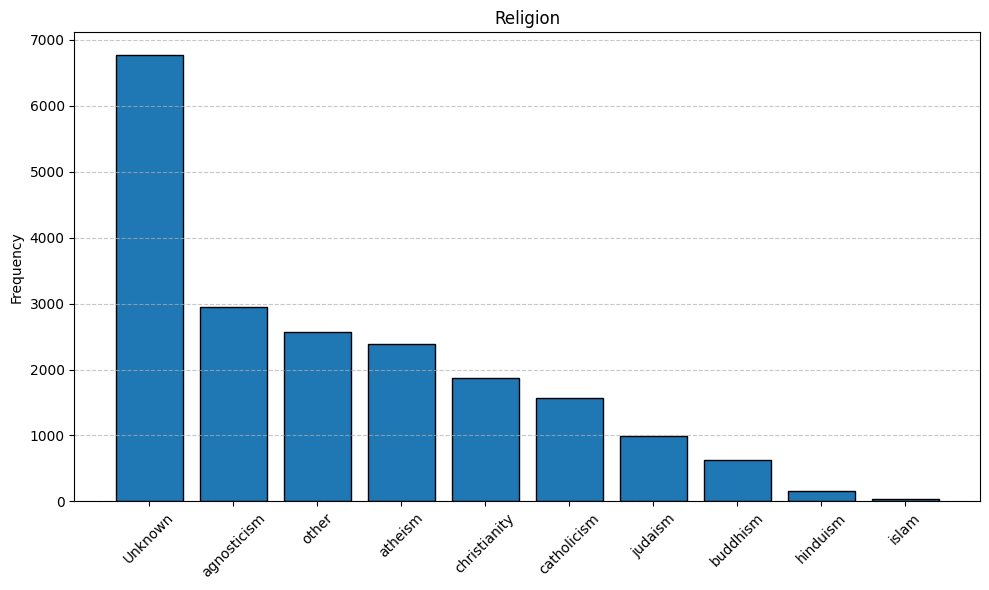

In [67]:
okcData['religion'].fillna('Unknown', inplace=True)
okcData['religion_word'] = okcData['religion'].str.split().str[0]
regli = okcData['religion_word']
sign_counts = regli.value_counts()

# Create a bar chart of religion distribution
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(sign_counts.index, sign_counts.values, edgecolor='black')  
plt.title('Religion') 
#plt.xlabel('Star Sign')  
plt.ylabel('Frequency') 
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [68]:
okcData['serious_mod'] = 0.5
okcData.loc[okcData['religion'].str.contains("and very serious about it",case = False), 'serious_mod'] = 1.0
okcData.loc[okcData['religion'].str.contains("and somewhat serious about it",case = False), 'serious_mod'] = 0.75
okcData.loc[okcData['religion'].str.contains("but not too serious about it",case = False), 'serious_mod'] = 0.5
okcData.loc[okcData['religion'].str.contains("and laughing about it",case = False), 'serious_mod'] = 0.25
dummies = pd.get_dummies(okcData['religion_word'])

In [69]:
dummies = dummies.astype(int)
for i in dummies.columns:
    dummies[i] = dummies[i] * okcData['serious_mod']
okcData = pd.concat([okcData, dummies], axis=1)
okcData.drop(['religion', 'religion_word', 'serious_mod', 'Unknown'], axis=1, inplace=True)

### **Cleaning Star Sign Data**


For star signs we divided each sign into its own category with one hot encoding applied.

Should a person have `it doesnt matter` as their modifier their starsign we would change their 1 to a 0.25. 

If they have a `its fun to think about` modifier we change their starsign value to a 0.5 if it was a 1.

If they have `it matters alot` as their modifier we leave their star sign value as 1 for that sign.

And should they leave their modifier empty it defaults to 0.75

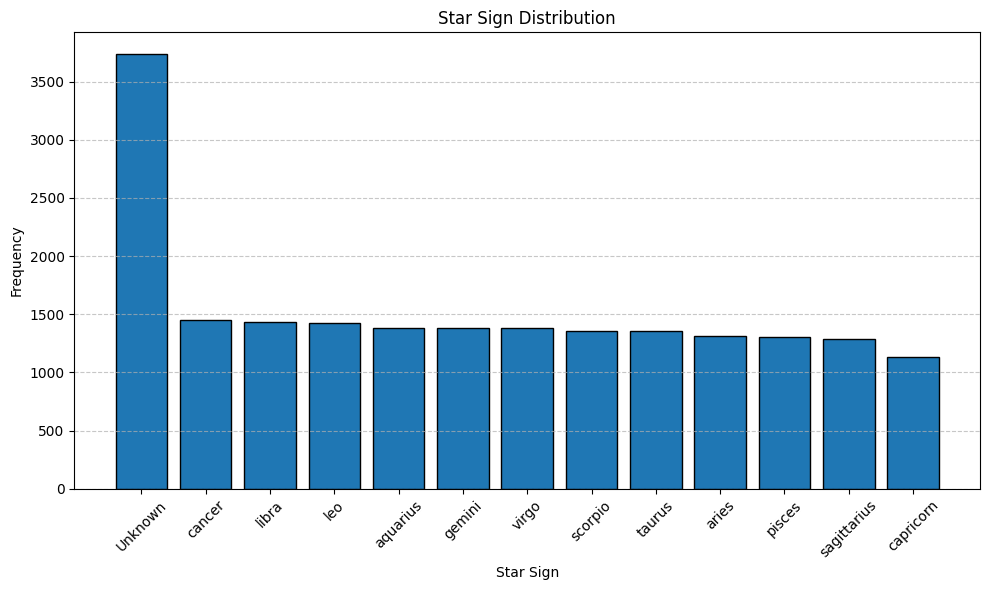

In [70]:
okcData['sign'].fillna('Unknown', inplace=True)
okcData['first_word'] = okcData['sign'].str.split().str[0]
signs = okcData['first_word']
sign_counts = signs.value_counts()

# Create a bar chart of star sign distribution
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(sign_counts.index, sign_counts.values, edgecolor='black')  
plt.title('Star Sign Distribution') 
plt.xlabel('Star Sign')  
plt.ylabel('Frequency') 
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [71]:
okcData['star_mod'] = 0.75
okcData.loc[okcData['sign'].str.contains("but it doesn&rsquo;t matter", case=False), 'star_mod'] = 0.25
okcData.loc[okcData['sign'].str.contains("and it&rsquo;s fun to think about", case=False), 'star_mod'] = 0.5
okcData.loc[okcData['sign'].str.contains("and it matters a lot", case=False), 'star_mod'] = 1
dummies = pd.get_dummies(okcData['first_word'])

In [72]:
dummies = dummies.astype(int)
for i in dummies.columns:
    dummies[i] = dummies[i] * okcData['star_mod']
okcData = pd.concat([okcData, dummies], axis=1)
okcData.drop(['sign', 'first_word', 'star_mod'], axis=1, inplace=True)

### **Cleaning Smoking Data**


For smoking `yes` is 1

`no` is 0

`nan` is assumed to be 0

`sometimes` & `when drinking` is 0.5

`trying to quit` is 0.25

In [73]:
okcData['smokes'].unique()

array(['sometimes', 'no', nan, 'when drinking', 'yes', 'trying to quit'],
      dtype=object)

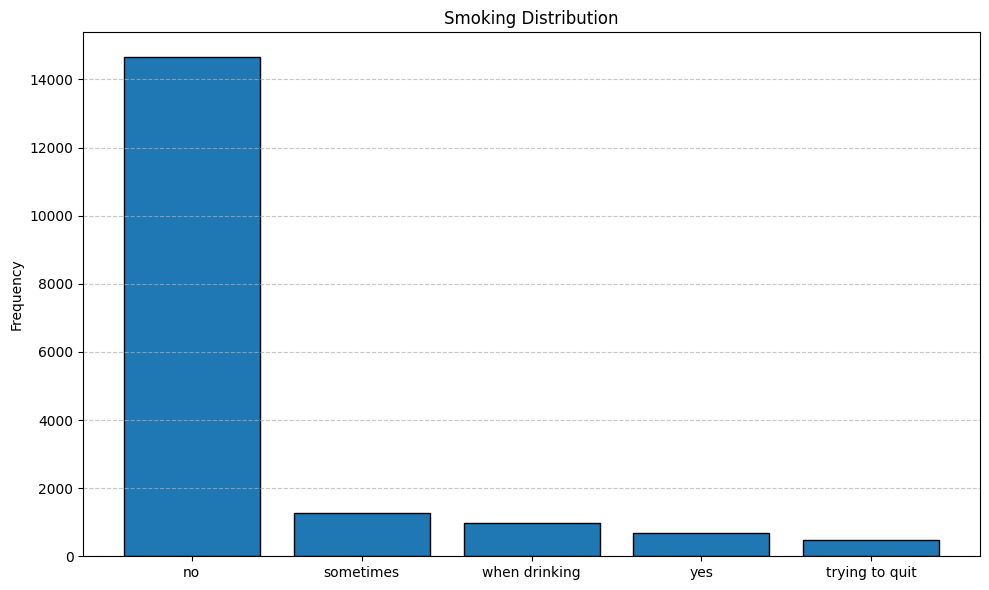

In [74]:
smokingset = okcData['smokes'].value_counts()
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(smokingset.index, smokingset.values, edgecolor='black')  
plt.title('Smoking Distribution')  # Add a title
plt.ylabel('Frequency')  
#plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

In [75]:
smoking_map = {'yes': 1, 'no': 0, 'sometimes': 0.5, 'when drinking': 0.5, 'trying to quit': 0.25}
okcData['smokes'] = okcData['smokes'].map(smoking_map)
okcData['smokes'].fillna(0, inplace=True)
#smokes has been converted to a 0-1 numerical data

### **Cleaning Spoken Language Data**

1. Split each language into a different column. 

2. Only consider languages that they are fluent in.

3. Assume that ones without fluency input are fluent

In [76]:
okcData['speaks'].unique()

array(['english', 'english (fluently), spanish (poorly), french (poorly)',
       'english, french, c++', ...,
       'english, french (okay), spanish (okay), italian (poorly), arabic (poorly)',
       'english (fluently), belarusan (okay), rotuman (fluently), tagalog (poorly), hawaiian (poorly)',
       'english (fluently), c++ (poorly), finnish (fluently), swedish (okay), german (poorly)'],
      dtype=object)

In [77]:
frames = ['L1','L2','L3','L4','L5']
lang = okcData[['speaks']].copy()

lang[frames] = okcData['speaks'].str.split(',',expand=True)

lang[frames].isnull().sum() #looking for and cleaning null values
for i in frames:
    lang[i] = lang[i].replace(np.NaN, 'None')


In [78]:
def fluent(txt):
    l1 = list(txt)
    l2 = list(txt.str.contains('(okay)|(poor)'))
    l3 = []
    for i,j in enumerate(l2):
        if j!=True:
            l3.append(l1[i])
        else:
            l3.append('None')
    return l3

In [79]:
for i in range(1,6):
    lang[f'L{i}'] = fluent(lang[f'L{i}'])


/var/folders/ky/q2_zvq7j05ng0wl3nxr3v_m00000gn/T/ipykernel_22215/3739476268.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  l2 = list(txt.str.contains('(okay)|(poor)'))


In [80]:
#removing the word fluent as we will assume people who did not indicate level of proficiency are fluent
for i in frames:
    lang[i] = lang[i].str.replace(r'\s*\(fluently\)|\(poorly\)|\(okay\)', '', regex=True) 


In [81]:
#strip whitespace 
for i in range(1,6):
    lang[f'L{i}'] = lang[f'L{i}'].str.strip()

#finding all the unique languages


unique_values = set()
for i in range(1, 6):
    unique_values = unique_values.union(lang[f'L{i}'].unique())

for col in list(unique_values):
    lang[col] = lang['speaks'].str.find(col).apply(lambda x: 0 if x==-1 else 1)

#clearing earlier L1-L5 columns
lang = lang.iloc[:,6:]
lang.head()
lang.sum(axis=0).sort_values(ascending=False)

english          19946
spanish           5495
french            2673
chinese           1291
german            1005
japanese           756
italian            746
c++                636
russian            451
portuguese         366
other              315
sign language      291
hindi              283
hebrew             274
tagalog            256
arabic             203
korean             187
latin              168
vietnamese         148
greek              147
lisp               145
farsi              126
swedish            114
thai                99
dutch               95
yiddish             86
ancient greek       86
swahili             83
turkish             73
polish              70
indonesian          69
esperanto           67
danish              63
czech               59
tamil               57
urdu                57
irish               53
sanskrit            49
afrikaans           49
persian             48
hawaiian            48
serbian             46
hungarian           46
norwegian  

In [82]:
lang_impt = lang[['english','spanish','french','chinese','german']]

In [83]:
lang_impt.head()

,english,spanish,french,chinese,german
0,1,0,0,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,0,0,0,1
4,1,0,0,0,0


In [84]:
#dropping the c++ languague we do not care about programming languages
#lang.drop('c++',axis=1,inplace=True)
okcData = pd.concat([okcData,lang_impt],axis=1)

### **Cleaning Bio Data**


Analysing text. 

To clean it we will do a set of steps:

1. Removal of contractions

2. Removal of punctuations

3. Tokenisation of the words (breaking them down into invidivual elements)

4. Removal of stopwords.

5. Lemmatizaton to reduce words to their base forms

6. Afterwards we can perform one of 3 analysis methods. 
    - Either Sentiment Analysis
    - Or converting the matrix to a TDF-IF matrix to perform further analysis

In [85]:
contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'll": "that will",
    "that's": "that is",
    "there'd": "there would",
    "there'll": "there will",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'd": "what did",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where'll": "where will",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why'd": "why did",
    "why'll": "why will",
    "why's": "why is",
    "won't": "will not"
}

def expand_contractions(text, contractions_dict):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

def remove_punctuation(txt):
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct



In [86]:
bio = okcData[['self summary']].copy()
bio['self summary'] = bio['self summary'].replace(np.NaN, 'None')
bio['self summary'] = bio['self summary'].apply(lambda x: expand_contractions(x, contractions)) #removal of contractions
bio['self summary'] = bio['self summary'].apply(lambda x: remove_punctuation(x)) #removal of puncutations 
bio['tokenised'] = bio['self summary'].apply(lambda x: x.split())
okcData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19946 entries, 0 to 19945
Columns: 206 entries, status to german
dtypes: bool(5), float64(31), int64(162), object(8)
memory usage: 30.7+ MB


In [87]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[:30]) #these are examples of stopwords we will be removing. we only want "keywords"

def remove_stopwords(i):
    cleaned = [word for word in i if word not in stopwords]
    return cleaned

bio['tokenised_no_sw'] = bio['tokenised'].apply(lambda x: remove_stopwords(x))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself']


In [88]:
def remove_numbers(i):
    cleaned = [word for word in i if not word.isdigit()]
    return cleaned

bio['tokenised_no_sw'] = bio['tokenised_no_sw'].apply(lambda x: remove_numbers(x))


In [89]:
wnl = nltk.WordNetLemmatizer()

def lemmatizer(i):
    cleaned = [wnl.lemmatize(word) for word in i]
    return cleaned
bio['tokenised_no_sw_lemma'] = bio['tokenised_no_sw'].apply(lambda x: lemmatizer(x))
bio['final'] = bio['tokenised_no_sw_lemma'].apply(lambda x:" ".join(x))

def sentiment(txt):
    return (TextBlob(txt).sentiment.polarity) #getting the sentiment of the bio

okcData['bio_sentiment_score'] = bio['final'].apply(lambda x: sentiment(x))

In [90]:
okcData.drop(['speaks','self summary','favourite books, movies etc.', 'typical activity on Fri night','i am good at...', 'status'],axis=1,inplace=True)

### **What the Data looks like after cleaning**

In [91]:
pd.options.display.max_columns = 15
okcData.head()

,sex,orientation,smokes,White,Asian,Hispanic / Latin,Black,...,virgo,english,spanish,french,chinese,german,bio_sentiment_score
0,m,straight,0.5,1,1,0,0,...,0.0,1,0,0,0,0,0.165206
1,m,straight,0.0,1,0,0,0,...,0.0,1,1,1,0,0,0.174627
2,m,straight,0.0,0,0,0,0,...,0.0,1,0,1,0,0,0.036184
3,m,straight,0.0,1,0,0,0,...,0.0,1,0,0,0,1,0.000000
4,m,straight,0.0,0,1,0,1,...,0.0,1,0,0,0,0,0.057273


---

## **Processing of Data**

After all of the data cleaning above, we are now able to process our data in order to retrieve the compatibility between two users. 

To this end we will be utilising two methods to allow for cross-checking to increase our program's effectiveness.

1. We will be using all of the newly cleaned numerical values and using the `pairwise_distances` function to calculate the similarity between two indiviudals. Afterwards we will apply a mask based on gender and orientation to it to prevent unfavourable combinations

2. We will be using K means clustering in order to achieve an aggregate clustering of users to initially refine the pool of users.

In [92]:
##Matrix 2 to store sex and orientation to apply to the compatibility matrix, e.g Straight man and Gay Female would not be compatible

okcMat2 = okcData[['sex','orientation']].copy()
okcData.drop(['sex','orientation'],axis=1,inplace=True)

In [93]:
okcMat2['userID'] = okcMat2.index
okcMat2["pref"] = okcMat2["sex"] + " " + okcMat2["orientation"]

# converting into category
okcMat2["pref"] = okcMat2["pref"].astype("category")

# getting the code for each category
okcMat2["code"] = okcMat2["pref"].cat.codes

# adding one to code so that it starts from 1
okcMat2["code"] = okcMat2["code"] + 1

okcMat2_pivoted = okcMat2[["userID","code"]].merge(okcMat2[["userID","code"]], on="code")

# getting the pivot table
okcMat2_pivoted = okcMat2_pivoted.pivot_table(index='userID_x',columns='userID_y',values='code')

okcMat2_pivoted.head(10)

userID_y,0,1,2,3,4,5,6,...,19939,19940,19941,19942,19943,19944,19945
userID_x,,,,,,,,,,,,,,,
0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,...,6.0,6.0,NaN,NaN,NaN,6.0,NaN
1,6.0,6.0,6.0,6.0,6.0,6.0,NaN,...,6.0,6.0,NaN,NaN,NaN,6.0,NaN
2,6.0,6.0,6.0,6.0,6.0,6.0,NaN,...,6.0,6.0,NaN,NaN,NaN,6.0,NaN
3,6.0,6.0,6.0,6.0,6.0,6.0,NaN,...,6.0,6.0,NaN,NaN,NaN,6.0,NaN
4,6.0,6.0,6.0,6.0,6.0,6.0,NaN,...,6.0,6.0,NaN,NaN,NaN,6.0,NaN
5,6.0,6.0,6.0,6.0,6.0,6.0,NaN,...,6.0,6.0,NaN,NaN,NaN,6.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN


In [94]:
okcMat2_pivoted_corrected = okcMat2_pivoted.replace([4,np.NaN,2,3,5,6],[1,1,0,0,0,0])

b = np.matrix(okcMat2_pivoted_corrected)
np.fill_diagonal(b,0.00) #all diagonal values are users with themselves, fill with 0s
okcMat2_pivoted_corrected = pd.DataFrame(b,columns=okcMat2_pivoted_corrected.columns)
okcMat2_pivoted_corrected.index = okcMat2_pivoted_corrected.columns


In [95]:
# User Similarity Matrix using 'cosine' measure
similarity_matrix = (1 - pairwise_distances(okcData, metric='cosine'))*100
print(similarity_matrix)

[[100.          39.83463144  11.36598792 ...  32.03856845  32.41885211
   27.89940021]
 [ 39.83463144 100.          49.66347064 ...  51.82822402  58.37970386
   39.15369723]
 [ 11.36598792  49.66347064 100.         ...  52.92023339  62.49230047
   38.38199265]
 ...
 [ 32.03856845  51.82822402  52.92023339 ... 100.          62.64113301
   47.11220732]
 [ 32.41885211  58.37970386  62.49230047 ...  62.64113301 100.
   30.4079705 ]
 [ 27.89940021  39.15369723  38.38199265 ...  47.11220732  30.4079705
  100.        ]]


In [96]:
# putting the diagonal elements to 0
a = np.matrix(similarity_matrix)
np.fill_diagonal(a,0.00)
final_df = pd.DataFrame(a)

In [97]:
final_df.head()

,0,1,2,3,4,5,6,...,19939,19940,19941,19942,19943,19944,19945
0,0.000000,39.834631,11.365988,38.344973,36.091949,30.176961,40.566705,...,35.993017,21.839143,47.318286,38.039900,32.038568,32.418852,27.899400
1,39.834631,0.000000,49.663471,42.078217,35.209928,41.591389,59.305076,...,22.671740,42.605135,55.365111,55.467703,51.828224,58.379704,39.153697
2,11.365988,49.663471,0.000000,38.286078,33.860054,43.744037,50.715970,...,12.864168,41.045833,35.498777,35.454382,52.920233,62.492300,38.381993
3,38.344973,42.078217,38.286078,0.000000,28.708956,47.626209,43.003395,...,36.638921,23.217073,30.082889,49.965001,44.799720,31.813204,45.457666
4,36.091949,35.209928,33.860054,28.708956,0.000000,49.798658,64.397429,...,14.104016,36.789769,43.015186,52.348895,48.133553,63.480765,24.534090


### **Similarity Matrix**

Here is our final similarity matrix between each individual a percentage is shown based on compatibility, which factors in sexuality

In [98]:
okcMat2_final = pd.DataFrame(np.multiply(np.matrix(final_df), np.matrix(okcMat2_pivoted_corrected)),columns=final_df.columns[:])
okcMat2_final.head() 

,0,1,2,3,4,5,6,...,19939,19940,19941,19942,19943,19944,19945
0,0.0,0.0,0.0,0.0,0.0,0.0,40.566705,...,0.0,0.0,47.318286,38.039900,32.038568,0.0,27.899400
1,0.0,0.0,0.0,0.0,0.0,0.0,59.305076,...,0.0,0.0,55.365111,55.467703,51.828224,0.0,39.153697
2,0.0,0.0,0.0,0.0,0.0,0.0,50.715970,...,0.0,0.0,35.498777,35.454382,52.920233,0.0,38.381993
3,0.0,0.0,0.0,0.0,0.0,0.0,43.003395,...,0.0,0.0,30.082889,49.965001,44.799720,0.0,45.457666
4,0.0,0.0,0.0,0.0,0.0,0.0,64.397429,...,0.0,0.0,43.015186,52.348895,48.133553,0.0,24.534090


In [99]:
okcMat2_final.describe()

,0,1,2,3,4,5,6,...,19939,19940,19941,19942,19943,19944,19945
count,19946.000000,19946.000000,19946.000000,19946.000000,19946.000000,19946.000000,19946.000000,...,19946.000000,19946.000000,19946.000000,19946.000000,19946.000000,19946.000000,19946.000000
mean,15.273512,20.535449,19.544566,18.142043,19.254966,21.149524,32.812417,...,11.907558,16.307433,41.340703,30.506228,32.495487,20.510533,35.788391
std,18.078682,23.548718,22.624554,20.975054,22.389081,24.177740,25.213388,...,14.384818,19.101053,18.013762,23.451382,24.692478,23.787454,13.914309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,31.346895,0.000000,0.000000,0.000000,29.390129
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.215214,...,0.000000,0.000000,42.532245,36.205606,39.284592,0.000000,37.378751
75%,31.552526,42.848608,40.212018,37.415080,39.864193,44.493949,53.552553,...,24.151873,33.640819,53.733016,49.358730,52.258461,42.895320,44.914456
max,76.530197,84.370317,83.483150,88.878146,82.218662,89.016553,89.224441,...,79.757110,84.658506,94.535358,94.557362,91.449578,88.913588,81.536091


### **K Means Clustering**

Below is our machine learning algorithm for the K means clustering of our dataset. This is to provide an estimate that we will work with to find users most compatible to a certain user. 

In [100]:
features = ['english','spanish','chinese','german','age__16-24','age__25-30','age__31-40','age__50+','smokes','bio_sentiment_score','likes pet _cat','likes pet _dog','owns pet _cat','owns pet _dog','fitness']
X = okcData[features]


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.set_output(transform='pandas')

X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.fillna(0)
X_scaled.isnull().sum()
X_scaled.head()

,english,spanish,chinese,german,age__16-24,age__25-30,age__31-40,age__50+,smokes,bio_sentiment_score,likes pet _cat,likes pet _dog,owns pet _cat,owns pet _dog,fitness
0,0.0,-0.616645,-0.263066,-0.230346,2.093690,-0.738892,-0.644915,-0.24815,1.712499,-0.055834,1.327487,1.041155,-0.365714,-0.4113,-0.823372
1,0.0,1.621680,-0.263066,-0.230346,-0.477626,-0.738892,1.550592,-0.24815,-0.415363,-0.000260,1.327487,1.041155,-0.365714,-0.4113,-0.823372
2,0.0,-0.616645,-0.263066,-0.230346,-0.477626,-0.738892,1.550592,-0.24815,-0.415363,-0.816910,-0.753303,-0.960472,2.734381,-0.4113,-0.823372
3,0.0,-0.616645,-0.263066,4.341286,2.093690,-0.738892,-0.644915,-0.24815,-0.415363,-1.030353,1.327487,-0.960472,-0.365714,-0.4113,-0.823372
4,0.0,-0.616645,-0.263066,-0.230346,-0.477626,1.353377,-0.644915,-0.24815,-0.415363,-0.692511,1.327487,1.041155,-0.365714,-0.4113,1.504917


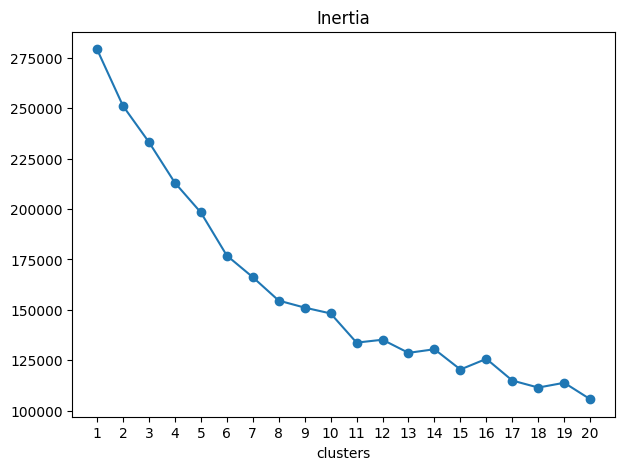

In [101]:

num_clusters=list(np.arange(1, 21))

inertias = []

for k in num_clusters:
  model = KMeans(n_clusters = k, n_init='auto')
  model.fit(X_scaled)
  inertias.append(model.inertia_)

fig7, ax7 = plt.subplots(figsize=(7, 5))

ax7.plot(num_clusters, inertias, '-o')
ax7.set(xticks=num_clusters, xlabel='clusters', title='Inertia')
fig7.savefig('figure_07.png')

Inertia refers to the sum of squared distances between each data point and its corresponding centroid. It is a measure of how tightly grouped the clusters are around their centroids. The number of clusters is chosen based on when the inertia changes the least between one node and the next, this is the [elbow](https://vitalflux.com/k-means-elbow-point-method-sse-inertia-plot-python/#:~:text=Elbow%20method%20requires%20drawing%20a,is%20the%20sample%20elbow%20point.) method.

In [102]:
k = 10 #
model = KMeans(n_clusters = k, n_init='auto',random_state=23)
model.fit(X_scaled)
okcData['membership'] = model.labels_
okcData.membership.value_counts()
okcData['sex'] = okcMat2['sex']

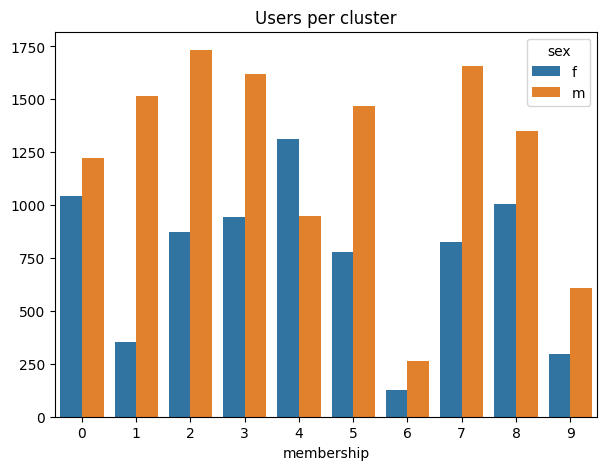

In [103]:
fig8, ax8 = plt.subplots(figsize=(7, 5))
sns.countplot(data=okcData, x='membership', ax=ax8, hue='sex')
ax8.set(title = 'Users per cluster', ylabel='')
fig8.savefig('figure_08.png')

In [104]:
okcData['orientation'] = okcMat2['orientation']
test_user = 3
okcData.loc[test_user:test_user] #since the test user is a straight male, we will look for straight female users in the same cluster as him.
users = okcData.loc[(okcData.sex == 'f') & 
               (okcData.membership == okcData.at[test_user, 'membership']) & 
               (okcData.orientation == 'straight')].index


---

## Results

Using both methods of processing our data as seen above, we are able to take a user and output the number of compatible users in the same region. As well as predict their top 10 matches.

In [105]:
print(f'We have found {len(users)} female users in the same cluster.\n ')

We have found 720 female users in the same cluster.
 


In [106]:
top_10 = okcMat2_final.iloc[:,test_user].sort_values(ascending=False)

In [107]:
top_10 = pd.DataFrame(top_10)
top_10.index.name = 'User ID'
top_10.columns = ['Match Percentage']
print(top_10.head(10))
print("\n")
print(top_10.iloc[239:249])

         Match Percentage
User ID                  
2377            88.878146
19239           88.062494
989             85.135600
6241            82.553694
10029           81.339716
11741           80.821353
7175            80.809990
8148            80.565048
3770            79.631138
4386            79.631138


         Match Percentage
User ID                  
1425            63.201097
4392            63.192306
17296           63.174660
3081            63.173392
14364           63.099527
466             63.051803
7405            63.033605
897             63.027404
19557           63.002405
13746           62.996175


As seen above, the 249th user has a 62.996 compatiblity with the `test_user`. Hence it supports our K means clustering algoritm as the match percentage tabulated is high.

In [108]:
features = features = ['english','spanish','chinese','german','age__16-24','age__25-30','age__31-40','age__50+','smokes','bio_sentiment_score','likes pet _cat','likes pet _dog','owns pet _cat','owns pet _dog','fitness','membership']
#adding membership to show their cluster

In [109]:
okcData.loc[test_user:test_user, features] #this is our test user 3

,english,spanish,chinese,german,age__16-24,age__25-30,age__31-40,...,bio_sentiment_score,likes pet _cat,likes pet _dog,owns pet _cat,owns pet _dog,fitness,membership
3,1,0,0,1,True,False,False,...,0.0,1,0,0,0,0.0,3


In [110]:
okcData.loc[2377:2377, features] #this is the test user's most compatible match

,english,spanish,chinese,german,age__16-24,age__25-30,age__31-40,...,bio_sentiment_score,likes pet _cat,likes pet _dog,owns pet _cat,owns pet _dog,fitness,membership
2377,1,0,0,0,True,False,False,...,0.442857,1,0,0,0,0.0,3


In [111]:
okcData.loc[19239:19239, features] #this is the test user's second most compatible match

,english,spanish,chinese,german,age__16-24,age__25-30,age__31-40,...,bio_sentiment_score,likes pet _cat,likes pet _dog,owns pet _cat,owns pet _dog,fitness,membership
19239,1,0,0,1,True,False,False,...,0.139477,1,1,0,0,0.0,3


In [112]:
okcData.loc[989:989, features] #this is the test user's third compatible match

,english,spanish,chinese,german,age__16-24,age__25-30,age__31-40,...,bio_sentiment_score,likes pet _cat,likes pet _dog,owns pet _cat,owns pet _dog,fitness,membership
989,1,1,0,1,True,False,False,...,-0.45,1,1,0,0,0.0,3


As seen above the K-means clustering (membership) groups the top results with the test_user. We're using this clustering method alongside the similarity matrix to improve compatibility accuracy. By putting similar profiles into clusters and measuring how alike they are, we can better match users. This cross-referencing between clustering and similarity helps us understand user preferences and make better recommendations for compatibility.